# Dimensionality Reduction

Machine Learning problems often have a large number of features involved. FOr larger problems this could be in thousands or even millions of features. Having such a arge number of features not only makes training on the data very slow but it could also make it harder for the model to find a good solution. We will prove this later. This problem is referred to as the *curse of dimensionality*.

In real world problems however it is possible to reduce the number of features. For example if we are working with the MNIST dataset (dataset of images of handwritten numbers), the data is in 0 and 1s. The black part of the image which is the the actual number and the white part of the image which is the background. Obviously the background is irrelevant and so we can remove all the features whose value is 1. Also there is a strong correlation between neighboring pixels in data. So we can reduce the number of features by finding the mean of the 2 neighboring pixels and mege them into a single pixel. You will also not lose too much information.

It is important to remember that reducing dimensionality does lead to some amount of information loss. We can intuitevely guess this, also we have seen it happen when we try to compress an image into the JPEG format and it loses some quality. This will speed up training but it could also lead to your model performing slightly worse. It also makes your pipelines more complex and hence harder to maintain. If training is too slow, you should firsst try to train the system using original data before you consider using dimensionality reduction. In some scrnarios reducing dimensionality of the training fata may remove noise and unnecessary details and could result in better performance this however will not happen generally, in most cases it will only speed up training.

Apart from speeeding up training, dimensionality reduction can be extremely useful for data visualisation. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of high dimensionality training data which could be useful for us to find some important insights by visually detecting patterns such as clusters. Data visualisation is also very important in order to communicate your conclusions to people who are not data scientist, such as decision makers who will use your results.

This notebook will be divided into the following sections: -
1. Curse of Dimensionality
2. Main Approaches for Dimensionality Reduction
3. PCA
4. Kernel PCA
5. LLE
6. Other Dimensionality Reduction Techniques

## 1. Curse of Dimensionality

We are very used to living in three dimensions, which is why we cannot intuitively understand a higher dimensional space. For example we find it very difficult to picture even a basic 4D hypercube, let alone a 200 dimensional ellipsoid bent in a 1000 dimensional space.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Dimension_levels.svg/480px-Dimension_levels.svg.png">
</center>

Things behave very differently when we are working in a high dimensional space. For example, if you pick a random point in a unit square, there is a about a 0.4% chance that it will be located less than 0.001 from a border (in other words it is very unlikely that the random point will be extreme along any dimension), however in a 10000 dimensional hypercube, this probability is greater than 99.999999%. Most points in a high dimensional space are very close to the border of the hypercube. (For a real world example: anyone you know is probably an extremist in at leat one dimension, for example how much sugar they put in their coffee, if you consider enough dimensions).

An even bigger difference, is that if you pick two points randomly in a unit square, the distance between these two points will on average be roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. If you picked two points randomly in a 1,000,000-dimensional hypercube, the average distance will be about 408.25 roughly $\sqrt{1,000,000/6}$. This is counterintiuitve, as how can two points be so far apart when they both lie in the same unit hypercube. The reason is that there is plently of space in high dimensions. As a result high-dimensional datasets are at risk of being very sparse, most training instances are likely to be far away from each other. This alsp means that a new instance will be far away from any training instance, making predictions much less reliable in lower dimensions since they will be based on large extrapolations. In short the more dimensions the training set has, the greater the risk of overfitting it.

In theory one solution to this problem is to increase the size of the training set to reach a sufficient density of training instances. However in practice the number of training instances required to reach a given density grows exponentially with the number of dimensions. FOr example with just 100 features (significantally lesse than in the MNIST problem), you would need more training instances than atoms in the observable universe in order for training instances to be within 0.1 of each other on average, assuming they were all spread out uniformly across all dimensions.

## 2. Main Approaches for Dimensionality Reduction

Before discussing specific dimensionality reduction algorithms, we will look into the two main approaches to reducing dimensionality: Projection and Manifold Learning.

### 2.1 Projection

In most real world scenarios data is not uniformally spread across all dimensions. This is because many of the features are constant and many of them are highly correlated. As a result most instances lie within or close to a much lower dimensional subspace of the high demensional space. To get an idea we will look at the following example.

<br>
<center>
<img src="https://raw.githubusercontent.com/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/63b8d7a91ff1ca2fdc35947a6a390c5a81085bd2//static/imgs/subspace_projection.png" height="300">
</center>
<br>

Here we can notice that all the training instances lie close to a plane. This is a lower dimensional (2D) subspace of the high dimensional (3D) space. Now if we project all the training instances onto this subspace, we will get a 2D dataset (represented by the solid lines) which looks like the following. Notice that the axes correspond to new features $z_1$ and $z_2$ (the coordinates of the projections on the plane).

<br>
<center>
<img src="https://raw.githubusercontent.com/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/63b8d7a91ff1ca2fdc35947a6a390c5a81085bd2//static/imgs/2d_projection.png" height="300">
</center>
<br>

However projection is not always the best approach to dimensionality reduction. This is because sometimes the subspace may twist and turn which is seen in the very popular swiss roll toy dataset.

<br>
<center>
<img src="https://miro.medium.com/max/1400/1*GIUnQnlgfSe3vZMoRkg1ww.png" height="400">
</center>
<br>

Simply projecting onto a plane, would squash different layers of the Swiss Roll together, as shown on the left side. However if we unroll the Swiss Roll along the axis of the plane, we get the 2D dataset on the right. This unrolling preserves the local structure of the Swiss Roll, but it distorts the global structure. This is why it is generally preferable to choose the axis to unroll along, rather than just projecting onto a plane.

<br>
<center>
<img src="https://miro.medium.com/max/1400/1*hXg4QP9Q0EsmJVNHi1DYsQ.png" height="200">
</center>
<br>

### 2.2 Manifold Learning

The Swiss Roll dataset, that we have saw earlier is an example of a 2D manifold. A 2D manifold is a 2D shape that can be bent or twisted in a higher dimensional space. Generally a d-dimensional manifold is part of an n dimensional space where $d < n$ that locally resembles a d-dimensional hyperplane. In the case of a swiss roll, $d = 2, n = 3$, it locally resembles a 2D place but it is rolled in the third dimension.

A hyperplane is a subspace whose dimensionality is 1 less than the ambient space around it. For example the hyperplane for a 3D space is a 2D plane while the hyperplane for a 2D space is a 1D space like a line.

Many dimensionality reduction algorithms work by modelling the manifold on which the training instances lie. This is called Manifold Learning. It relies on the maniforld assumptio which is also called the maniforld hypothesis: states that most real-world high dimensional datasets lie close to a much lower dimensional manifold. This assumption is very often emperically observed.

The manifold assumption is very often accompanied by another illicit assumption: that the task at hand (classification or regression for example) will be simpler if expressed in the lower dimensional space of the manifold. For example in the image given below where we try to classify the points, after we have unrolled the swiss roll the deicision boundary is a lot simpler. This is seen in the top row.

This however does not always hold true, for example in the bottom row, the decision boundary for the higher dimensional space is at $x_1 = 5$. This decisiom boundary is very simple in the 3D space but it is more complex in the 2D unrolled manifold where it is made up of a collection of four independent line segments.

<br>
<center>
<img src="https://pbs.twimg.com/media/EbNbDv5UcAg2c40.png" height="400">
</center>
<br>

## 3. Principal Component Analysis (PCA)

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it. The following figure shows the result of applying PCA to the 3D Swiss Roll dataset. The projection (represented by the dashed lines) preserves the distances between the instances.

This section will be divided into the following subsections: -

1. Preserving the Variance
2. Principal Components
3. Projecting Down to d Dimensions
4. Using Scikit-Learn
5. Explained Variance Ratio
6. Choosing the Right Number of Dimensions
7. PCA for Compression
8. Randomized PCA
9. Incremental PCA

### 3.1 Preserving the Variance

Before you project the training set onto a lower dimensional hyperplane, you first need to choose the right hyperplane. In the example simple 2D dataset given below, there are three different axes (1D hyperplanes). On the right is the result of the projection of the dataset onto each of the axes. As seen the projection onto the solid line preserves the maximum variance, while the projection onto the dotted line preserves the minimum variance. The dashed line preserves an intermediate amount of variance.

<br>
<center>
<img src="https://miro.medium.com/max/1400/0*qKESl4pUx0p6vqrv" height="300">
</center>
<br>

It seems reasonable to select the axis that preserved the maximum amount of variance, as it will likly lose the least amount of information as compared to the other projections. Another way to justify this choice is that it is the axis that minimises the mean squared distance between the original dataset and its projection onto that axis. This is the idea behind PCA.

### 3.2 Principal Components

PCA identifies the axis that acounts for the largest amount of variance in the training set. It is the solid line. It also finds a second axis orthogonal to the first one that accounts for the largest amount of remaining variance. For our above example this is the solid and dotted line. Solid line is chosen first we then need to find axis orthogonal to it so that is the dotted line only as the dashed line is not orthogonal. if it were a higher dimensional dataset, PCA would find a third axis, orthogonal to the previous two axes and a fourth, fifth and so on - as many axes ars the number of dimensions in the dataset.

The $i^{th}$ axis is called the $i^{th}$ principal component (PC). The first PC is the axis on which vector $c_1$ lies and the second PC is the axis on which the vector $c_2$ lies. THe first two PCs are the orthogonal axes on which the two arrows lie, on the plane, and the third PC is the axis orthogonal to that plane.

For each principal componnet, PCA find a zero-centered unit vector pointing in the direction of the PC. Since two opposing unit vectors lie on the same axis, the direction of the unit vectors returned bu PCA is not stable: if you perturb the training set slightly and run PCA again, the unit vectors may point in the opposite direction as the original vectors. However, they will generally lie on the same axes. In some cases, a pair of unit vectors may even rotate or swap (if the variances along the axes are close), but the plane they define will generally remain the same.

So the question of how to find the prinicpal components of a training set arises. There is a standard matrix factorization technique called Singular Value Decomposition (SVD) that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U \Sigma V^T$ where $V$ contains the unit vectors that efine all the principal components that we are looking for, as shown in the following equation.

Equation: Principal Components Matrix

$V = \begin{bmatrix} c_1 & c_2 & \dots & c_n \end{bmatrix}$


The following python code uses NumPys svd() function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first two PCs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
X = np.linspace(start=-1., stop=1., num=100)
y = X + np.random.normal(size=100)/7.
X.shape, y.shape

((100,), (100,))

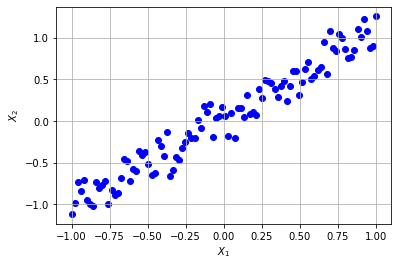

In [3]:
plt.scatter(X, y, c='blue')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.grid()
plt.show()

In [4]:
X = np.concatenate((X[..., None], y[..., None]), axis=1)
X.shape

(100, 2)

In [5]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
c1, c2

(array([0.67836909, 0.73472129]), array([ 0.73472129, -0.67836909]))

These two 2D points represent the unit vector points (origin at (0,0)) corresponding to the 2 principal components (axes that preserve variance). PCA assumes that the dataset is centered around the origin, but scikit-learn implementation takes care of centering the data for you.

PCA assumes the dataset is centered around the origin. As we will see later on if you implement PCA yourself, you will need to ensure that the data is centered first.

### 3.3 Projecting Down to d Dimensions

Once you have identified all the principal components, you can reduce the dimensionality of the dataset down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

For example in the figure given earlier, the 3D dataset is projected down to the 2D plane defined by the first two principal components. As a result the 2D projection looks very much like the original 3D dataset.

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality d, compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first d columns of $V$ as shown in the equation given below.

Equation: Projecting the training set down to d dimensions

$X_{d-proj} = XW_d$

The following python code projects the training set onto the plane defined by the first two principal components.

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

Now you know how to reduce the dimensionality of any dataset down to any number of dimensions, while preserving as much variance as possible.

### 3.4 Using Scikit-Learn

Scikit-Learn's PCA class implements PCA using SVD decomposition. The following code applies PCA to reduce the dimensionality of the dataset down to 2 dimensions. It automatically takes care of centering the data.

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its componenets_ attribute holds the transpose of $W_d$ (e.g. the unit vector that defines the first principal componenet is qual to pca.components_.T[:, 0]).

### 3.5 Explained Variance Ratio

Another useful piece of information is the explained variance ratio of each principal component, available via the explained_variance_ratio_ variable. It indicates the proportion of the dataset's variance that lies along the axis of each principal component.

In [8]:
pca.explained_variance_ratio_

array([0.98660824, 0.01339176])

In the above scenario, the first principal component alone explains 98.7% of the variance, which is much more than the second principal component (0.12%): the first PC is much more informative than the second one.

### 3.6 Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g. 95%). Unless of course, you are reducing dimensionality for data visualization - in that case you will generally want to reduce the dimensionality down to 2 or 3.

The following code computes PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set's variance.

In [9]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You could then set n_components to d and run PCA again. There is however a much better way to do this. Instead of specifying the number of principal components you want to preserve, you can set n_components to be a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve. The following code computes the minimum number of dimensions required to preserve 95% of the training set's variance.

In [10]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

Yet another option is to plot the explained variance as a function of the number of dimensions (simply plot the cumsum). There will usually be an elbow in the curve, where the explained variance stops growing fast. You can then select the number of dimensions that will add up to a good explained variance ratio. In this figure given below you can see that reducing the dimensionality down to 100 dimensions would not lose much explained variance.

<br>
<center>
<img src="https://miro.medium.com/max/864/1*obeP0ttQR00oi3gRu2DgSA.png" height="400">
</center>
<br>

### 3.7 PCA for Compression

After dimensionality reduction using PCA, the training set takes up much less space. As an example we can try applying PCA to the MNIST dataset while preserving 95% of the variance, each instance has 150 features,compared to the previous 784 features. SO while most of the vairnace is preserved the dataset is now less than 20% of its original size. This is a reasonable compression ratio and you can see how the sizr reduction can speed up training a classification algorithm such as an SVM classifier tremendously.

It is also possible to decompress the reduced dataset back to 784 dimensions. However, the reconstructed data will not be the same as the original data, since the projection lost a bit of information (within the 5% variance that was dropped). The mean squared distance between the original data and the reconstructed data (compressed and then decompressed) is called the reconstruction error.

The following code compresses the MNIST dataset down to 154 deimsnions, then decompresses it back to 784 dimensions. It uses the mean squared error as a performance measure of the reconstruction.

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [12]:
X, y = datasets.fetch_openml(name='mnist_784', return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46900, 784), (23100, 784), (46900,), (23100,))

In [13]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

The figure given below shows a few digits from the MNIST dataset, then the same digits after being compressed and decompressed. You can see that there is slight image quality loss but the digits are still mostly intact.

<br>
<center>
<img src="https://miro.medium.com/max/1400/1*QGCLtW_UVgF8iGyqFoU0KA.png" height="300">
</center>
<br>

Equation: PCA inverse transformation, back to the original number of dimensions

$X_{recovered} = X_{d-proj}W_d^T$

### 3.8 Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called Randomized PCA that quickly finds an approximation of the first d principal components. Its computational complexity is $O(m \times d^2) + O(d^3)$, instead of $O(m \times n^2) + O(n^3)$ for the full SVD approach, so it is dramatically faster than full SVD when d is much smaller than n.

In [14]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

By default, svd_solver is set to "auto", which means Scikit-Learn automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use the full SVD approach, you can set the svd_solver hyperparameter to "full".

### 3.9 Incremental PCA

One problem with the preceding implementation of PCA is that it requires the whole training set to fit in memory in order for the SVD algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have been developed: you can split the training set into mini-batches and feed an IPCA algorithm one mini-batch at a time. 

This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new instances arrive).

The following code splits the MNIST dataset into 100 mini-batches (using NumPy's array_split() function) and feeds them to Scikit-Learn's IncrementalPCA class to reduce the dimensionality of the MNIST dataset down to 154 dimensions. You must call the partial_fit() method with each mini-batch, instead of the usual fit() method with the whole training set.

In [15]:
from sklearn.decomposition import IncrementalPCA

In [16]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

Alternatively, you can use the NumPy memmap class, which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory: the class loads only the data it needs in memory, when it needs it. Since the IncrementalPCA class uses only a small part of the array at any given time, the memory usage remains under control. This makes it possible to call the fit() method, as seen in the following code. 

```
X_mm = np.memmap(filename=filename, dtype='float32', mode='readonly', shape=(m,n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)
```

## 4 Kernel PCA

The kernel trick is a mathematical technique that implicitly maps instances into a very high-dimensional space (called the feature space), enabling nonlinear classification and regression with Support Vector Machines. It is often useful with PCA as well, especially with complex nonlinear datasets. The same kernel trick we use earlier for SVMs can also be applied to PCA, making it possible to perform complex nonlinear projections for dimensionality reduction. This is caled Kernel PCA (kPCA). It is often good at preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a twisted manifold. The follwing code uses sklearns KernelPCA class to perform kPCA with an RBF kernel. The hyperparameter gamma controls how much the dataset is stretched.

In [17]:
X, _ = datasets.make_swiss_roll(n_samples=1000, noise=1)

In [18]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X_train)
X_reduced.shape

(46900, 2)

The figure given below shows the Swiss Roll, reduced to two dimensions using a linear kernel (equivalent to using the PCA class), an RBF kernel and a sigmoid kernel. The linear kernel preserves the Swiss roll's shape, but the RBF kernel and the sigmoid kernel distort it. The RBF kernel preserves the Swiss roll's global shape, but it twists and stretches the roll in some places. The sigmoid kernel preserves the Swiss roll's global shape, but it twists and stretches the roll in some places. The sigmoid kernel preserves the Swiss roll's global shape, but it twists and stretches the roll in some places.

<br>
<center>
<img src="https://img2018.cnblogs.com/blog/1012590/201904/1012590-20190406130102775-1737791858.png" height="300">
</center>
<br>

### 4.1 Selecting a Kernel and Tuning Hyperparameters

Since kPCA is an unsupervised learning algorithm, tje is no obvious performance measure that we an use to help select the best kernel and hyerparameter values. Since dimensionalityb reduction si often used as a preparation step for a supervised learning task, such as classification, we can use grid search to select the kernel and hyperparameter values that leads to the best performance on that task. We can do this by creating a pipeline that first reduces dimensionality to 2 dimensions using kPCA, and then applies LogisticRegression for classification. It will then use GridSearchCV to find the kernel and gmma value for kPCA in order to get the best classification accuracy and the end of the pipeline. The following is a code implementation of the above idea.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid = GridSearchCV(clf, param_grid, cv=3)
grid.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

The best kernel and hyperparameters are then available using the best_params_ variable.

In [21]:
print(grid.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'rbf'}


Another approach, which is entirely unsupervised, is to select the kernel and hyperparameter values that yield tje lowerst reconstruction error. Note that the reconstruction is not as easy as it is with linear PCA. This is because of the following reason. First check the diagram of Kernel PCA and the reconstruction pre-image error.

<br>
<center>
<img src="https://nbviewer.org/github/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/static/imgs/reconstruction_vis.png" width="500">
</center>

The original swiss roll is the top left image, and the resulting 2D dataset after kPCA is applied using an RBF kernel is top right. Thanks to te kernel trick, this transformation is mathematically equivalent to using the feature map $\varphi$ to map the training sset to an infinite-dimensional feature space, then projecting the transformed training set down to 2D using linear PCA.

If we could invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in the feature space, not in the original space (e.g. like the one represented by an X in the diagram). Since the feature space is infinite-dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately it is possible to find a point in the original space that would map close to the reconstructed point, THis ic alled the reconstruction **pre-image**. once you have this pre-image you can measure its sequare distance to the original instance. You can then select the kernel and hyperparameters that minimize this reconstruction pre-image error.

A question arises as to how we can perform this reconstruction, one solution is tro train a supervised regression model with the projected instances as the training set and the original instances as the targets. Sklearn wil do this automatically if you set fit_inverse_transform = True, as shown in the following code.

In [22]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

By default, fit_inverse_transform=False and KernelPCA has no inverse_transform() method. You can set fit_inverse_transform=True, but it will take much longer to train, and it will consume much more memory.

Now we can compute the reconstruction pre-image error.

In [23]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

33.184110185279536

## 5 LLE

Locally Linear Embedding (LLE) is another powerful nonlinear dimensionality reduction (NLDR) technique. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. It works by first measureing how each training instance linearly relates to its closes neighbors and then looking for a low dimensional represnetation of the training set where these local relationships are best preserved. This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code uses Scikit-Learn's LocallyLinearEmbedding class to unroll the Swiss roll, while trying to preserve the local relationships between instances. The n_neighbors hyperparameter tells how many neighbors each instance should be aware of. The figure given below shows the result.

In [24]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

The resulting 2D dataset is shown in the figure given below. The Swiss roll is completely unrolled and the distenaces between instances are locally well preserved, However datasets are not preserved on a larger scale, the left part of the roll is stretched while the right part is squeezed. Regardless LLE did a pretty good job at modelling the manifold.

<br>
<center>
<img src="https://nbviewer.org/github/Akramz/Hands-on-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/master/static/imgs/swiss_unroll.png" height="400">
</center>
<br>

LLE works by: for each training instance $x^(i)$, the algorithm identifies its $k$ closest neighbors (in the code given above it was set as k = 10), then it tries to reconstruct $x^(i)$ as a linear function of these neighbors. To elaborate it finds the weights $w_{i, j}$ such that the mean squared distance between $x^(i)$ and $\sum_{j=1}^{m} w_{i, j} x^(j)$ is as small as possible assuming $w_{i,j} = 0$ if $x^(j)$ is not one of the k closest neighbors of $x^(i)$. Thus the first step of LLE is the ocnstrained optimation problem given below where $W$ is the weight matrix contataining all the weights $w_{i,j}$. The second constraint simply normalises the weights for each training instance $x^(i)$.

Equation: LLE step one: Linearly modelling local relationships

$ \hat{W} = argmin_{W} \sum_{i=1}^{m} \left\| x^(i) - \sum_{j=1}^{m} w_{i, j} x^(j) \right\|^2 $

subject to $\sum_{j=1}^{m} w_{i, j} = 1 $ for $i = 1,2,...,m$ and $w_{i, j} = 0$ if $x^{{(j)}$ is not one of the k closest neighbors of $x^{(i)}$

After this step the weight matrix $\hat{W}$ (containing the weights $\hat{w}_{i,j}$) encodes the local linear relationship between the training instances. The second step is to map the training instances into $d$-dimensional space (where $d \lt n$) while preserving these local relationships as much as possible. If $z^{(i)}$ is the image of $x^{(i)}$ in this $d$-dimensional space, then we want the squared distance between $z^{(i)}$ and $\sum \limits_{j=1}^{m} \hat{w}_{i, j} z^{(j)}$ to be as small as possible. This idea leads to the unconstrained optimization problem given below. It looks very similar to the first step, but instead of keeping the instances fixed and finind optimal weights we are doing the reverse: keeping the weights fixed and finding the optimal positions of the instances images in the low-dimensional space. Note that $Z$ is the matrix containing all $z^{(i)}$.

Equation: LLE step two: Reducing dimensionality while preserving relationships

$ \hat{Z} = argmin_{Z} \sum_{i=1}^{m} \left\| z^{(i)} - \sum_{j=1}^{m} \hat{w}_{i, j} z^{(j)} \right\|^2 $

Sklearns LLE implementation has the following computational complexity. $O(m \log(m)n \log(k))$ for finding the $k$ nearest eighbors, $O(mnk^3)$ for optimizing the weights and $O(dm^2)$ for constructing the low-dimensional representation Unfortunately the $m^2$ in the last term makes this algorithm scale poorly to very large datasets. However, if you set the n_neighbors hyperparameter to a very small value (e.g. 2), it will run much faster at the cost of a slightly worse reconstruction in the reduced dimensionality space.

## 6 Other Dimensionality Reduction Techniques

There are many other dimensionality reduction techniques. Several of which are available in Scikit-Learn. Some of the popular ones are as follows:

1. Random Projections
2. Multidimensional Scaling (MDS)
3. Isomap
4. t-Distributed Stochastic Neighbor Embedding (t-SNE)
5. Linear Discriminant Analysis (LDA)

### 6.1 Random Projections

Random Projections are a simple and fast dimensionality reduction technique. It projects the data to a lower-dimensional space using a random linear projection. This may sound horrible in practice but it turns out that uch a random projection is actually very likely to preserve the ditnces well, as was demonstrated mathematically in a famous lemma. The qualtiy of the dimensionality reduction depends on the number of instancea and the target dimensionality, but surprisingly not on the intitial dimensionality. It can be used using the sklearn.random_projection package.

### 6.2 Multidimensional Scaling (MDS)

Reduces dimensionality while trying to preserve the distances between the instances. It is a Manifold Learning technique that does not rely on projections like the previous algorithms. It works by first measureing how each training instance linearly relates to its closes neighbors and then looking for a low dimensional represnetation of the training set where these local relationships are best preserved. This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise. Can be used using the sklearn.manifold package.

### 6.3 Isomap

Creates a graph by connecting each instance to its nearest neoghbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances. The geodesic distance between two nodes in a graph is the number of nodes on the shortest path between these nodes. Can be used using the sklearn.manifold package.

### 6.4 t-Distributed Stochastic Neighbor Embedding (t-SNE)

Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. it is mostly used for visualisation, in particular to visualise clusters of instances in high-dimensional space (to visualise the MNIST images in 2D). Can be used using the sklearn.manifold package.

### 6.5 Linear Discriminant Analysis (LDA)

Is a classification algorithm, but during training it learns the most discriminative axes between the classes and these axes an then be used to define the hyperplane onto which to project the data, The benefit of this approach is that the projection will keep the classes as far away as possible, so LDA is a good technique to reduce the deimnsionality before running another classification algorithm such as an SVM classifier. Can be used using the sklearn.discriminant_analysis package.

## 7 Exercises

1. Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training and the remaining 10,000 for testing). Then train a Random Forest classifier on the training set and time how long it takes, then evaluate the resulting model on the test set. Next use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next evaluate the classifier on the test set: how does it compare to the previous classifier? Hint: you can use the %timeit magic command to measure the execution time.
2. Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class. Alternatively, you can replace each dot in the scatterplot with the corresponding instance's class (e.g., 0, 1, 2, etc.), or even plot scaled down versions of the digit images themselved (if you plot al digits the visualisation will be too cluttered so you should either draw a random sample or plot an nstance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits. Now try using PCA, LLE, or MDS and compare the resulting visualizations.
